In [1]:
from scipy.stats import truncnorm, multivariate_normal, norm
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd

# Hyperparameteres

In [113]:
# Parameters
mu_1 = 25
mu_2 = 25
sigma_1 = 25/3
sigma_2 = 25/3
sigma_t = 25/6

# Moment Matching

In [114]:
mu = mu_1 - mu_2
sigma_total_squared = sigma_t * sigma_t + sigma_1 * sigma_1 + sigma_2 * sigma_2
   
def p_t(t):
    return norm.pdf(t, loc=mu, scale=np.sqrt(sigma_total_squared))

def p_y_given_t(t, y_obs):
    if (y_obs == -1 and t < 0) or (y_obs == 1 and t > 0):
        return 1  # p(y | t ) = 1 based on your conditions
    else:
        return 0

# Function to calculate the combined probability
def p_t_given_y(t, y_obs):
    return p_t(t) * p_y_given_t(t, y_obs)

# def p_t_given_y(t, mu1, mu2, sigma_t, sigma1, sigma2, y):
    
    
#     # Gaussian part: N(mu1 - mu2, sqrt(sum of sigmas^2))
#     gaussian_part = norm.pdf(t, loc=mu, scale=np.sqrt(sigma_total_squared))
    
#     # CDF part: phi((mu2 - mu1) / sqrt(sum of sigmas^2))
#     cdf_part = norm.cdf(mu / np.sqrt(sigma_total_squared))
        
#     if y == 1 and t > 0: 
#         return gaussian_part * (1 / (1 - cdf_part))
#     elif y == -1 and t < 0: 
#         return gaussian_part * (1 / cdf_part)
#     else:
#         return 0  # Return 0 if the condition is not met


In [115]:

# Define functions
def multiplyGauss(m1, s1, m2, s2):
    s = 1 / (1 / s1 + 1 / s2)
    m = (m1 / s1 + m2 / s2) * s
    return m, s

def divideGauss(m1, s1, m2, s2):
    m, s = multiplyGauss(m1, s1, m2, -s2)
    return m, s

def truncGaussMM(a, b, m0, s0):
    a_scaled, b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0)
    mean = truncnorm.mean(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0))
    var = truncnorm.var(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0))
    return mean, var

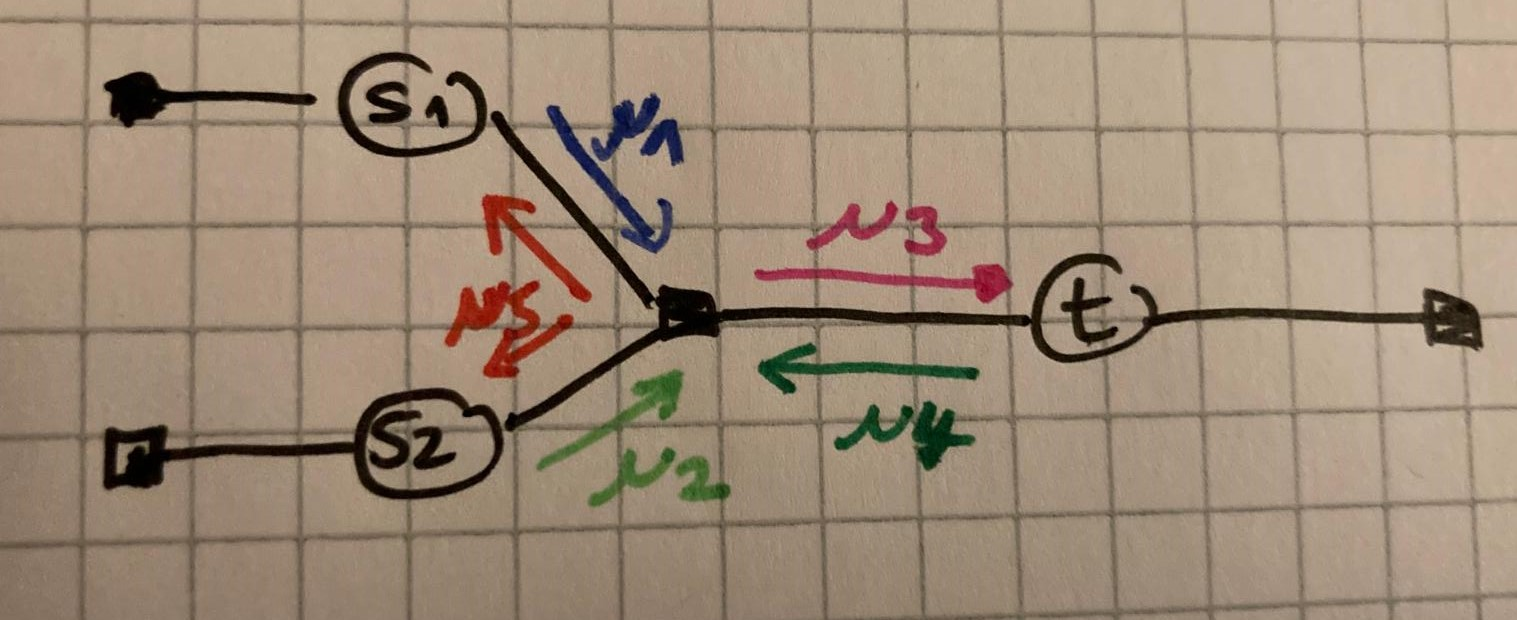

In [120]:
mean_msg1 = mu_1
mean_msg2 = mu_2

var_msg1 = sigma_1**2
var_msg2 = sigma_2**2
var_t = sigma_t**2

y = 1 

# Message 3 from factor f(t,s1,s2) to node t
mean_msg3 = mean_msg1 - mean_msg2
var_msg3 = var_msg1  + var_msg2 + var_t

# Do moment matching of the marginal of t
if y == 1:
    a, b = 0, np.inf
else:
    a, b = -np.inf, 0

# Compute the message from t to f(t, s1, s2)
mean_msg4, var_msg4 = truncGaussMM(a, b, mean_msg3, var_msg3)

# Compute the message from f(t, s1, s2) to s1,s2
mean_msg5, var_msg5 = divideGauss(mean_msg4, var_msg4, mean_msg3, var_msg3)

# Update priors for s1 and s2 
mean_p_s1, var_p_s1 = multiplyGauss(mean_msg5 + mean_msg2, var_msg5 + var_msg2, mean_msg1, var_msg1)
mean_p_s2, var_p_s2 = multiplyGauss(mean_msg1 - mean_msg5, var_msg5 + var_msg1, mean_msg2, var_msg2)

# Output results
print("Updated Priors:")
print(f" - s1: mean={mean_p_s1:.4f}, var={var_p_s1:.4f}")
print(f" - s2: mean={mean_p_s2:.4f}, var={var_p_s2:.4f}")


Updated Priors:
 - s1: mean=29.7701, var=48.3000
 - s2: mean=20.2299, var=48.3000


In [117]:
# DMoment Matching posterior parameters
mu_1_post_mm, sigma_1_post_mm = mean_p_s1, np.sqrt(var_p_s1)
mu_2_post_mm, sigma_2_post_mm = mean_p_s2, np.sqrt(var_p_s2)

# Gibbs Sampling posterior parameters 
mu_1_post_gibbs, sigma_1_post_gibbs = 29.62406435, np.sqrt(50.46528493)
mu_2_post_gibbs, sigma_2_post_gibbs = 20.58850616, np.sqrt(54.83086857)

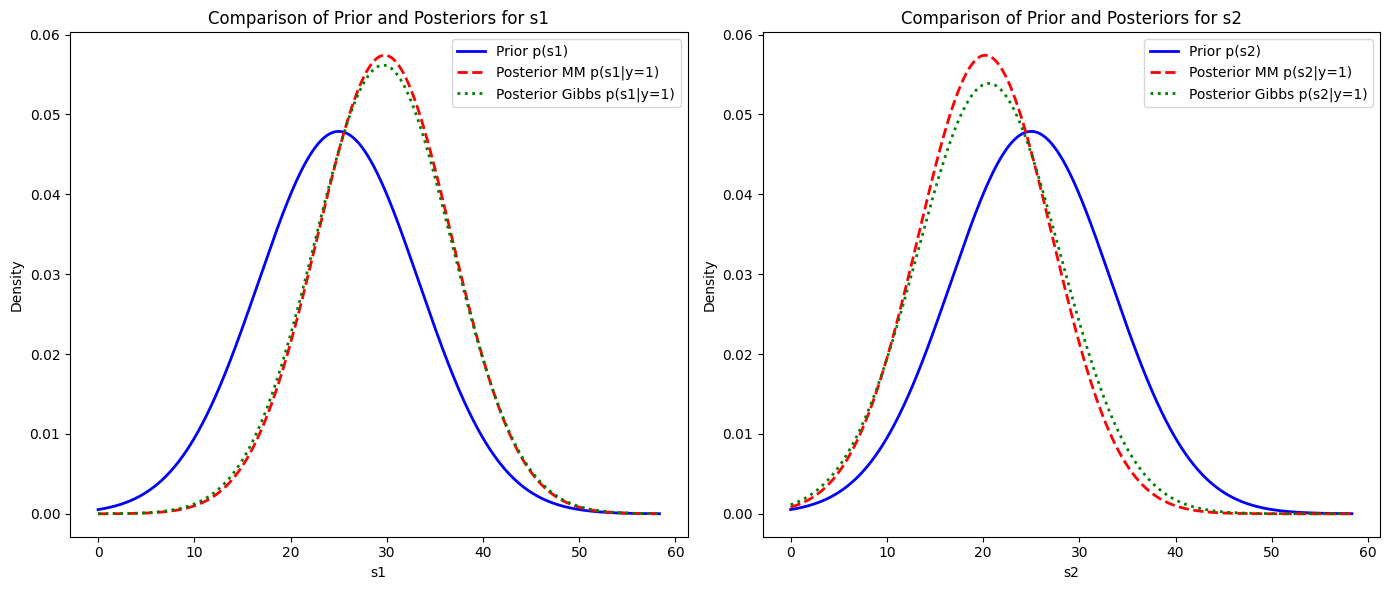

In [119]:
# Define x-axis range for s1 and s2 (non-negative starting at 0)
x_s1 = np.linspace(0, mu_1 + 4*sigma_1, 1000)
x_s2 = np.linspace(0, mu_2 + 4*sigma_2, 1000)

# Compute PDFs for priors and posteriors
prior_s1 = norm.pdf(x_s1, mu_1, sigma_1)
posterior_s1_mm = norm.pdf(x_s1, mu_1_post_mm, sigma_1_post_mm)
posterior_s1_gibbs = norm.pdf(x_s1, mu_1_post_gibbs, sigma_1_post_gibbs)

prior_s2 = norm.pdf(x_s2, mu_2, sigma_2)
posterior_s2_mm = norm.pdf(x_s2, mu_2_post_mm, sigma_2_post_mm)
posterior_s2_gibbs = norm.pdf(x_s2, mu_2_post_gibbs, sigma_2_post_gibbs)

# Plot for s1
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(x_s1, prior_s1, label="Prior p(s1)", color='blue', lw=2)
plt.plot(x_s1, posterior_s1_mm, label="Posterior MM p(s1|y=1)", color='red', lw=2, linestyle='dashed')
plt.plot(x_s1, posterior_s1_gibbs, label="Posterior Gibbs p(s1|y=1)", color='green', lw=2, linestyle='dotted')
plt.title("Comparison of Prior and Posteriors for s1")
plt.xlabel("s1")
plt.ylabel("Density")
plt.legend()

# Plot for s2
plt.subplot(1, 2, 2)
plt.plot(x_s2, prior_s2, label="Prior p(s2)", color='blue', lw=2)
plt.plot(x_s2, posterior_s2_mm, label="Posterior MM p(s2|y=1)", color='red', lw=2, linestyle='dashed')
plt.plot(x_s2, posterior_s2_gibbs, label="Posterior Gibbs p(s2|y=1)", color='green', lw=2, linestyle='dotted')
plt.title("Comparison of Prior and Posteriors for s2")
plt.xlabel("s2")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

we have to add sampling gibbs histogram to figure